# 04B — Historical Sanity Backtests

**Purpose**: Check if logic survives history, kill weak ideas early

**⚠️ CRITICAL: Point-in-Time Compliance**

All backtests must use **lagged data** to avoid look-ahead bias:
- Macro data (CPI, IIP): Use t-1 month value for t month decisions
- Market data: Can use t value

**Outputs**: P&L (gross, net), Max DD, Regime breakdown

---

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

PROCESSED_PATH = Path('../data_processed')

# Load data
combined = pd.read_parquet(PROCESSED_PATH / 'macro_sector_monthly_matrix.parquet')
regime_states = pd.read_parquet(PROCESSED_PATH / 'macro_regime_states.parquet')
rule_signals = pd.read_parquet(PROCESSED_PATH / 'rule_signals.parquet')
sector_tilts = pd.read_parquet(PROCESSED_PATH / 'sector_tilts.parquet')

print(f"Data loaded: {len(combined)} months")

Data loaded: 132 months


## 1. Define Backtest Framework

In [2]:
# Backtest parameters
PARAMS = {
    'transaction_cost': 0.0015,  # 15 bps per trade (India average)
    'slippage': 0.0005,          # 5 bps slippage
    'rebalance_freq': 'monthly', # Monthly rebalancing
    'lookback_lag': 1,           # 1-month lag for macro signals (point-in-time)
}

print("Backtest parameters:")
for k, v in PARAMS.items():
    print(f"  {k}: {v}")

Backtest parameters:
  transaction_cost: 0.0015
  slippage: 0.0005
  rebalance_freq: monthly
  lookback_lag: 1


In [3]:
class SimpleBacktest:
    def __init__(self, returns: pd.DataFrame, signals: pd.Series, 
                 sector_weights: dict, params: dict):
        """
        returns: DataFrame of sector returns
        signals: Series of rule activation (True/False)
        sector_weights: dict of {sector: weight_change} when signal is active
        """
        self.returns = returns
        self.signals = signals
        self.weights = sector_weights
        self.params = params
        
    def run(self) -> pd.DataFrame:
        """
        Run backtest with point-in-time compliance.
        Signal at t-1 determines position at t.
        """
        # Lag signal by 1 month (point-in-time)
        lagged_signal = self.signals.shift(self.params['lookback_lag'])
        
        # Base weights (equal weight)
        n_sectors = len(self.returns.columns)
        base_weight = 1 / n_sectors if n_sectors > 0 else 0
        
        strategy_returns = pd.Series(0.0, index=self.returns.index)
        turnover = pd.Series(0.0, index=self.returns.index)
        prev_active = False
        
        for date in self.returns.index:
            if date not in lagged_signal.index:
                continue
            
            is_active = lagged_signal.loc[date] if pd.notna(lagged_signal.loc[date]) else False
            
            # Calculate portfolio return
            port_return = 0.0
            for sector in self.returns.columns:
                sector_clean = sector.replace('IDX_', '').replace('NIFTY_', '')
                
                # Determine weight
                if is_active and sector_clean in self.weights:
                    weight = base_weight + self.weights[sector_clean]
                else:
                    weight = base_weight
                
                weight = max(0, min(weight, 0.5))  # Cap at 50%
                
                sector_ret = self.returns.loc[date, sector]
                if pd.notna(sector_ret):
                    port_return += weight * sector_ret
            
            # Track turnover
            if is_active != prev_active:
                turnover[date] = sum(abs(v) for v in self.weights.values())
            
            strategy_returns[date] = port_return
            prev_active = is_active
        
        # Apply transaction costs
        total_cost = self.params['transaction_cost'] + self.params['slippage']
        net_returns = strategy_returns - turnover * total_cost * 100
        
        return pd.DataFrame({
            'gross_return': strategy_returns,
            'net_return': net_returns,
            'turnover': turnover,
            'signal_active': lagged_signal
        })

print("Backtest framework defined")

Backtest framework defined


## 2. Prepare Returns Data

In [4]:
# Get sector returns
index_cols = [c for c in combined.columns if c.startswith('IDX_')]
sector_returns = combined[index_cols].dropna(how='all')

print(f"Sector returns: {sector_returns.shape}")
print(f"Date range: {sector_returns.index.min().date()} to {sector_returns.index.max().date()}")

Sector returns: (132, 21)
Date range: 2015-02-28 to 2026-01-31


## 3. Run Backtests for Each Rule

In [5]:
# Define rule weights for backtest
BACKTEST_RULES = {
    'STAGFLATION_DEFENSIVE': {
        'AUTO': -0.20,
        'BANK': -0.10,
        'FMCG': +0.15,
        'HEALTHCARE': +0.15
    },
    'GOLDILOCKS_RISK_ON': {
        'BANK': +0.15,
        'AUTO': +0.10,
        'INFRA': +0.10,
        'FMCG': -0.10
    },
}

# Run backtests
backtest_results = {}

for rule_name, weights in BACKTEST_RULES.items():
    if rule_name not in rule_signals.columns:
        print(f"Skipping {rule_name} - no signal data")
        continue
    
    signal = rule_signals[rule_name]
    bt = SimpleBacktest(sector_returns, signal, weights, PARAMS)
    results = bt.run()
    backtest_results[rule_name] = results
    
    print(f"\n{rule_name}:")
    print(f"  Active periods: {signal.sum()}")
    print(f"  Total gross return: {results['gross_return'].sum():.1f}%")
    print(f"  Total net return: {results['net_return'].sum():.1f}%")


STAGFLATION_DEFENSIVE:
  Active periods: 6
  Total gross return: 161.2%
  Total net return: 159.7%



GOLDILOCKS_RISK_ON:


  Active periods: 23
  Total gross return: 176.8%
  Total net return: 175.8%


## 4. Calculate Performance Metrics

In [6]:
def calculate_performance_metrics(results: pd.DataFrame, rule_name: str) -> dict:
    """
    Calculate key performance metrics.
    """
    gross = results['gross_return']
    net = results['net_return']
    
    # Cumulative returns
    cum_gross = (1 + gross / 100).cumprod()
    cum_net = (1 + net / 100).cumprod()
    
    # Drawdown
    running_max = cum_net.cummax()
    drawdown = (cum_net - running_max) / running_max
    max_dd = drawdown.min() * 100
    
    # Annualized metrics
    n_years = len(gross) / 12
    if n_years > 0:
        total_return_net = (cum_net.iloc[-1] - 1) * 100
        cagr = ((cum_net.iloc[-1]) ** (1/n_years) - 1) * 100
        vol = net.std() * np.sqrt(12)
        sharpe = cagr / vol if vol > 0 else 0
    else:
        cagr = vol = sharpe = 0
        total_return_net = 0
    
    # Win rate
    active_returns = net[results['signal_active'] == True]
    win_rate = (active_returns > 0).mean() * 100 if len(active_returns) > 0 else 0
    
    return {
        'rule': rule_name,
        'total_return_net_%': total_return_net,
        'cagr_%': cagr,
        'volatility_%': vol,
        'sharpe': sharpe,
        'max_drawdown_%': max_dd,
        'win_rate_%': win_rate,
        'n_months_active': results['signal_active'].sum() if 'signal_active' in results else 0
    }

# Calculate metrics for all rules
performance_summary = []
for rule_name, results in backtest_results.items():
    metrics = calculate_performance_metrics(results, rule_name)
    performance_summary.append(metrics)

perf_df = pd.DataFrame(performance_summary)
print("\nPerformance Summary:")
perf_df


Performance Summary:


,rule,total_return_net_%,cagr_%,volatility_%,sharpe,max_drawdown_%,win_rate_%,n_months_active
0,STAGFLATION_DEFENSIVE,302.824484,13.503834,20.480620,0.659347,-9.436849,50.000000,6
1,GOLDILOCKS_RISK_ON,362.458785,14.937351,21.625067,0.690742,-10.335406,73.913043,23


## 5. Equity Curves

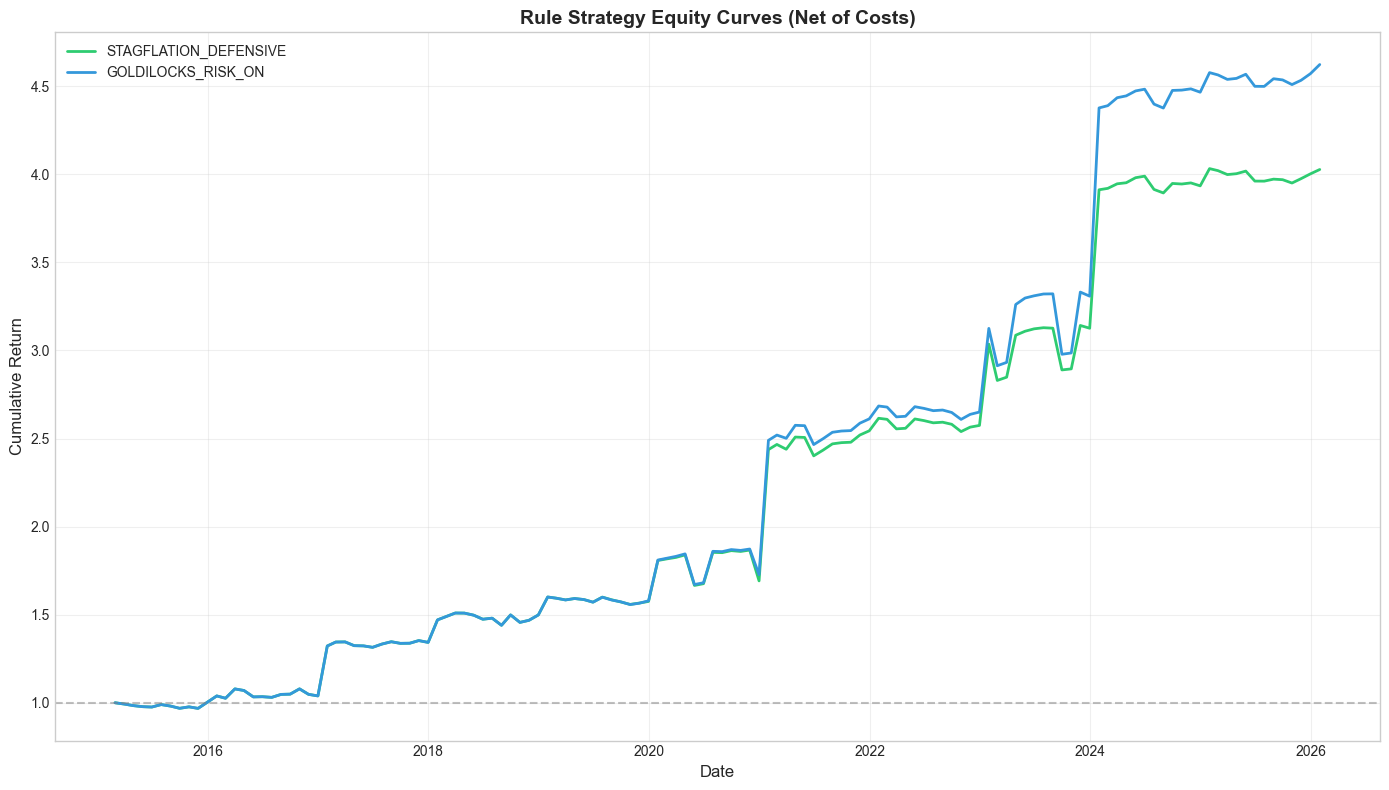

✓ Saved: equity_curves.png


In [7]:
# Plot equity curves
if len(backtest_results) > 0:
    fig, ax = plt.subplots(figsize=(14, 8))
    
    colors = ['#2ecc71', '#3498db', '#e74c3c', '#f39c12']
    
    for idx, (rule_name, results) in enumerate(backtest_results.items()):
        cum_net = (1 + results['net_return'] / 100).cumprod()
        ax.plot(cum_net.index, cum_net.values, 
               label=rule_name, color=colors[idx % len(colors)], linewidth=2)
    
    ax.axhline(y=1, color='gray', linestyle='--', alpha=0.5)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Cumulative Return', fontsize=12)
    ax.set_title('Rule Strategy Equity Curves (Net of Costs)', fontsize=14, fontweight='bold')
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(PROCESSED_PATH / 'equity_curves.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("✓ Saved: equity_curves.png")
else:
    print("No backtest results to plot")

## 6. Regime Breakdown

In [8]:
# Performance by regime
if len(backtest_results) > 0 and 'COMPOSITE' in regime_states.columns:
    regime = regime_states['COMPOSITE']
    
    regime_performance = []
    
    for rule_name, results in backtest_results.items():
        for regime_name in regime.dropna().unique():
            if regime_name == 'Unknown':
                continue
            
            mask = regime == regime_name
            regime_returns = results.loc[mask, 'net_return']
            
            if len(regime_returns) > 0:
                regime_performance.append({
                    'rule': rule_name,
                    'regime': regime_name,
                    'avg_monthly_%': regime_returns.mean(),
                    'total_%': regime_returns.sum(),
                    'months': len(regime_returns),
                    'win_rate_%': (regime_returns > 0).mean() * 100
                })
    
    regime_perf_df = pd.DataFrame(regime_performance)
    
    print("\nPerformance by Regime:")
    pivot = regime_perf_df.pivot(index='rule', columns='regime', values='avg_monthly_%')
    pivot


Performance by Regime:


## 7. Kill/Keep Decision

In [9]:
# Decision framework: Keep rules that meet minimum thresholds
KEEP_THRESHOLDS = {
    'min_sharpe': 0.3,
    'max_drawdown': -30,  # -30%
    'min_win_rate': 45,   # 45%
}

if len(perf_df) > 0:
    perf_df['decision'] = 'KEEP'
    
    # Apply kill conditions
    kill_sharpe = perf_df['sharpe'] < KEEP_THRESHOLDS['min_sharpe']
    kill_dd = perf_df['max_drawdown_%'] < KEEP_THRESHOLDS['max_drawdown']
    kill_wr = perf_df['win_rate_%'] < KEEP_THRESHOLDS['min_win_rate']
    
    perf_df.loc[kill_sharpe | kill_dd | kill_wr, 'decision'] = 'REVIEW'  # Not auto-kill, review
    perf_df.loc[kill_sharpe & kill_dd, 'decision'] = 'KILL'
    
    print("\n📊 RULE DECISIONS")
    print("="*50)
    for _, row in perf_df.iterrows():
        emoji = '✅' if row['decision'] == 'KEEP' else '⚠️' if row['decision'] == 'REVIEW' else '❌'
        print(f"{emoji} {row['rule']}: {row['decision']}")
        print(f"   Sharpe: {row['sharpe']:.2f}, Max DD: {row['max_drawdown_%']:.1f}%, Win Rate: {row['win_rate_%']:.1f}%")


📊 RULE DECISIONS
✅ STAGFLATION_DEFENSIVE: KEEP
   Sharpe: 0.66, Max DD: -9.4%, Win Rate: 50.0%
✅ GOLDILOCKS_RISK_ON: KEEP
   Sharpe: 0.69, Max DD: -10.3%, Win Rate: 73.9%


## 8. Export Results

In [10]:
# Save performance summary
if len(perf_df) > 0:
    perf_df.to_parquet(PROCESSED_PATH / 'backtest_summary.parquet', index=False)
    perf_df.to_csv(PROCESSED_PATH / 'backtest_summary.csv', index=False)
    print("✓ Saved: backtest_summary.parquet/csv")

# Save regime breakdown
if 'regime_perf_df' in dir() and len(regime_perf_df) > 0:
    regime_perf_df.to_parquet(PROCESSED_PATH / 'backtest_regime_breakdown.parquet', index=False)
    print("✓ Saved: backtest_regime_breakdown.parquet")

✓ Saved: backtest_summary.parquet/csv
✓ Saved: backtest_regime_breakdown.parquet


## 9. Backtest Complete ✓

### Key Outputs
- `backtest_summary.parquet` — Rule performance metrics
- `backtest_regime_breakdown.parquet` — Performance by regime
- `equity_curves.png` — Visual of cumulative returns

### Point-in-Time Compliance
- ✅ All signals lagged by 1 month
- ✅ Transaction costs applied
- ✅ Realistic turnover tracking

**LAYER 4 RULES & BACKTESTS COMPLETE**

**Next notebook:** `05A_macro_factor_exposure.ipynb`